<a href="https://colab.research.google.com/github/ExCaLBBR/ExCaLBBR_Projects/blob/main/SocioenvironmentalGeometry/code/JaySPUR_ProjectPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Concept Geometry analysis pipeline
For PNAS manuscript: <br>
Authors: <b>Roberto Vargas; Timothy Verstynen </b><br>
Codebook created by: <b>Roberto Vargas </b><br>
Acknowledgements: <b>Nahom Mossazghi</b><br>
<br>
<b>Pipeline includes:</b><br>
*   Data restructuring: Sorting accoring to word list
*   Regression predicting pair edged using: <i>Race; Gender; Income; Age; NewsBias</i>
*   Mediation analysis:


<br>
<br>

In [ ]:
#@title Install dependancies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from itertools import combinations
import math
import statsmodels as sm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import csv
from tqdm import tqdm
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind


In [ ]:
#@title Define utility functions
def weightedHeatmap(PairData, words, PlotHM):

    '''
    Restructure RT into matrix data structure

    '''

    Wmat = np.zeros((len(words),len(words)))
    t = 0
    z = 0

    for i in range(len(words)):
        for j in range(len(words)):

            if i == j:
                Wmat[i,j] = np.NaN

            elif j > i:
                Wmat[i,j] = PairData[t]
                Wmat[j,i] = PairData[t]
                t += 1


    if PlotHM == 1:
        plt.imshow(Wmat,  cmap='RdBu', vmin=-7, vmax=7)
        plt.colorbar()
        plt.xticks(range(len(words)), words, rotation='vertical')
        plt.yticks(range(len(words)), words)
        plt.show()

    return Wmat

def ccbi_randperm(ntimes, nperm):

    '''
      p = ccbi_randperm(nitems,nperm)
      Parameters: number of items, number of random permutations
      Output: a matrix with nperm rows;
      Each row is an index of permuted item positions.

      returns a matrix (n,nitems)
      each row is a random permutation of nitems (labelled 1:nitems)
      produces n such permutations
      the random seed is changed at every call

    '''

    p = np.zeros((nperm, ntimes))
    for i in range(nperm):
        p[i,:] = np.random.permutation(ntimes)

    return p


def splitHalf_Reliability(dat, perm):
    """
    Compute the reliability within a measure
    This analysis splits the data into 2 halfs and then averages the similarity structure
    This analysis is repeated

    """
    pSplit = ccbi_randperm(dat.shape[1], perm)

    rho = []
    for p in range(perm):
        # Split data
        if dat.shape[1] % 2 == 0:  # is even
            frstHalf = dat.iloc[:, pSplit[p, :(pSplit.shape[1]//2)]]
            scndHalf = dat.iloc[:, pSplit[p, (pSplit.shape[1]//2):]]

        elif dat.shape[1] % 2 == 1:  # is odd
            frstHalf = dat.iloc[:, pSplit[p, :int(np.floor(pSplit.shape[1]/2))]]
            scndHalf = dat.iloc[:, pSplit[p, int(np.ceil(pSplit.shape[1]/2)):]]
        # Avg dist of each half
        avgFrstHalf = frstHalf.mean(axis=1)
        avgScndHalf = scndHalf.mean(axis=1)

        # Correlate halves
        rhoI = np.corrcoef(avgFrstHalf, avgScndHalf)[0,1]

        rho.append(rhoI)

    rho = np.mean(rho)

    return rho



def regPairDiff(X, Y, perm):

    '''

    Predict pair differences among a X in Y
 	X is vector or matrix of variables used to predict Y
 	Y is a continuous vector
 	perm is the number of permutations used to compare against the observed beta
  Dimensions of X and Y should all align

    '''

    # Generate the permutations
    pComb = ccbi_randperm(X.shape[0],perm)

    # Generate constant
    con = np.ones(X.shape[0])
    con = con.reshape(con.shape[0], 1)

    # Estimate observed beta
    xModel = np.concatenate((con, X), axis=1)
    betaObs, _, _, _ = np.linalg.lstsq(xModel.astype('float'), Y, rcond=None)

    betaPerm = []

    for p in range(perm):
        pCombi = pComb.astype(int)
        yPerm = Y[pCombi[p,:]]
        bPerm, _, _, _ = np.linalg.lstsq(xModel.astype('float'), yPerm, rcond=None)
        betaPerm.append(bPerm)

    betaPerm = pd.DataFrame(betaPerm)

    pval =[]
    for b in range(len(betaObs)):
      if betaObs[b] > 0:
        nBbeyond =  len(np.where(np.array(betaPerm[b]) > betaObs[b])[0])
        pb = nBbeyond/perm
        pval.append(pb)
      elif betaObs[b] < 0:
        nBbeyond = len([x for x in np.array(betaPerm[b]) if x < betaObs[b]])
        pb = nBbeyond/perm
        pval.append(pb)

      else:
        raise ValueError('observed beta is exactly equal to 0')

    return betaObs, pval, betaPerm


In [ ]:
#@title Clean up Dataframes mask out participants who didn't complete all parts of session
#Data path
path = 'https://github.com/ExCaLBBR/ExCaLBBR_Projects/raw/main/SocioenvironmentalGeometry/data/'

# Load Demographic PRaM data
datDemo = pd.read_csv (path + 'demographic.csv', header=1)
datPRaM = pd.read_csv (path + 'df_taskPRaM.csv', header=0)
pairLab = pd.read_csv (path + 'PRaM_pairLabels.csv', header=None)
news = pd.read_csv (path + 'df_News_coded.csv', header=1)

#remove misc row and incomplete sessions
datDemo = datDemo.drop(labels=0, axis=0)
datDemo = datDemo.reset_index(drop=True)
datDemo['Question Key'] = [sub[: -2] for sub in datDemo['Question Key']]
datPRaM = datPRaM.drop(['Participant Private ID'], axis=1)
datPRaM = datPRaM.reset_index(drop=True)
news = news.drop(labels=0, axis=0)
news = news.reset_index(drop=True)

#Identify participants who did not complete all measures
lst1 = datDemo['Question Key']
lst2 = news['Question Key']
exPart = list(set(lst1) - set(lst2))
mask = datDemo['Question Key'].str.contains(exPart[0], na=True) #If the number of participants to exclude exceeds 1 you will need a for loop
datDemo = datDemo[~mask]
datPRaM = datPRaM[~mask]

#reset index just in case
datDemo = datDemo.reset_index(drop=True)
datPRaM = datPRaM.reset_index(drop=True)
news = news.reset_index(drop=True)

#Sort pairs accoring to prefered combination
words = ['police', 'firefighter', 'neighbors(yours)', 'conservatives(political)', 'liberals(political)', 'healthcare', 'voting', 'immigration', 'religion', 'science', 'anger', 'fear', 'joy', 'love', 'sadness', 'trust']
combinations_list = [list(c) for c in combinations(words, 2)]


In [ ]:
#Isolate Race variable
raceCol = datDemo.columns.get_loc('raceEth_v2')
bIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('Black or African American')].index
wIndx =  datDemo[datDemo.iloc[:,raceCol].str.contains('White')].index
blackCode = np.concatenate([np.ones(len(bIndx)), np.zeros(len(wIndx))])

# Isolate Age variable and subset sample by race
ageCol = datDemo.columns.get_loc('age')
bAge = datDemo.iloc[bIndx,ageCol]
wAge = datDemo.iloc[wIndx,ageCol]
bAge = bAge.replace(1984, 38)
Age = np.concatenate([bAge, wAge])

# Isolate Income variable and subset sample by race
incCol = datDemo.columns.get_loc('Income')
bIncome = datDemo.iloc[bIndx,incCol]
wIncome = datDemo.iloc[wIndx,incCol]
Income = np.concatenate([bIncome, wIncome])
Income = pd.Series(Income)

# Isolate Gender variable and create concatonated vector
gendCol = datDemo.columns.get_loc('gender')
bGender = datDemo.iloc[bIndx,gendCol]
wGender = datDemo.iloc[wIndx,gendCol]
Gender = np.concatenate([bGender, wGender])
Gender = pd.Series(Gender)

#Homogenize Gender responses to F and M and remove genders with insufficient representation
remIndx = Gender.str.contains(pat = 'non', case=False) | Gender.str.contains(pat = 'Gen', case=False)
Gender.loc[remIndx]= 'R'
femIndx = Gender.str.contains(pat = 'f',case=False) | Gender.str.contains(pat = 'w',case=False)
Gender.loc[femIndx]= 'F'
maleIndx = Gender.str.contains(pat = 'an',case=False) | Gender.str.contains(pat = 'al',case=False)
Gender.loc[maleIndx]= 'M'

#Isolate News bias and subset sample by race
newsbiasCol = news.columns.get_loc('avgBias')
bNewsBias = news.iloc[bIndx,newsbiasCol]
wNewsBias = news.iloc[wIndx,newsbiasCol]
NewsBias = np.concatenate([bNewsBias, wNewsBias])
NewsBias = pd.Series(NewsBias)

#Remove underrepesented gender identities (i.e, non-bianary)
blackCode = blackCode[~remIndx]
Gender = Gender[~remIndx]
Income = Income[~remIndx]
Age = Age[~remIndx]
NewsBias = NewsBias[~remIndx]

print(f'Sample of participant completing session = ', len(datDemo['Question Key']))
print(f'Of',len(datDemo['Question Key']), ',' ,(len(bIndx)+len(wIndx)), 'participants identified as non-Hispanic White(', len(wIndx),') or Black/AfricanAmerican(', len(bIndx),')')
print(f'of', (len(bIndx)+len(wIndx)), ',', len(Gender), 'participants identified as Female(', sum(femIndx==1), ') or Male(', sum(maleIndx==1),')')
print(f'The final analyzed sample contains', len(blackCode), 'participants!')

Sample of participant completing session =  585
Of 585 , 572 participants identified as non-Hispanic White( 294 ) or Black/AfricanAmerican( 278 )
of 572 , 567 participants identified as Female( 286 ) or Male( 281 )
The final analyzed sample contains 567 participants!


Mean age for sample: 39.46 ( SD = 12.12 )


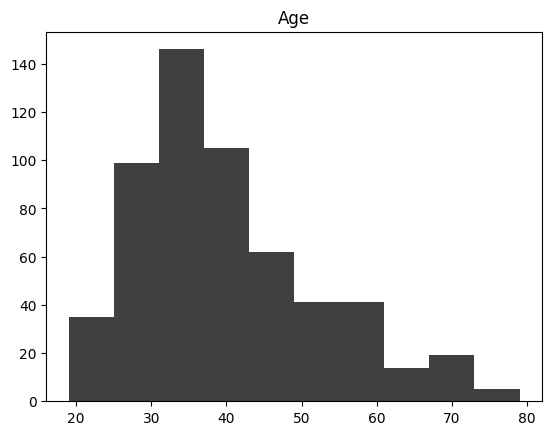

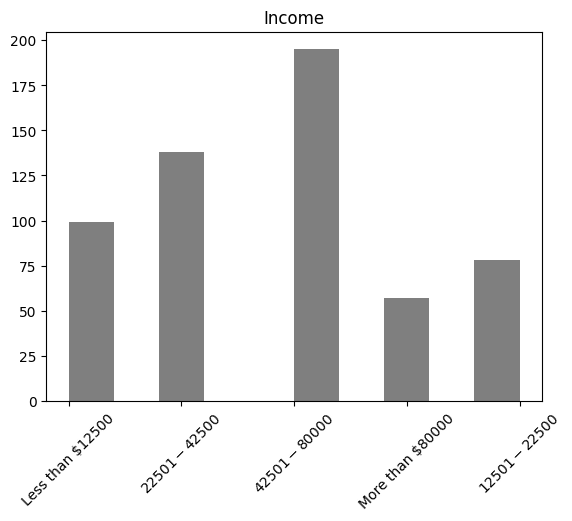

In [ ]:
#Participant descriptive statistics

#!!!!!CHANGE TO BE OVERALL Statistics rather than breaking it up by age
Age_mean = np.mean(Age)
Age_sd = np.std(Age)

print(f'Mean age for sample:', round(Age_mean,2), '( SD =', round(Age_sd,2), ')')

# Plot age histograms
plt.hist(Age, alpha=0.75, color= 'k')
plt.title('Age')
plt.show()

# Plot age histograms [Figure out how to sort x axis labels]

customSort = {'Less than $12500':0, '$12501-$22500':1, '$22501-$42500':2, '$42501-$80000':3 ,'More than $80000':4}
IncPlot = Income.sort_values(key=lambda x: x.map(customSort))
plt.hist(IncPlot,
         alpha=0.5,
         color='k')
plt.title('Income')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# re-organize the dataframe according to the word combination
wPairLabel = []
x = []                  #index orders are saved as list
for i in range(len(combinations_list)):

    # Extract pair rating
    idx0 = pairLab[pairLab.iloc[:,1].str.contains(combinations_list[i][0].replace('(', r'\(').replace(')', r'\)'))].index
    idx1 = pairLab[pairLab.iloc[:,2].str.contains(combinations_list[i][1].replace('(', r'\(').replace(')', r'\)'))].index
    pIndx = idx0.intersection(idx1)

    # Extract pair label
    wPairLabeli = combinations_list[i][0] + '-' + combinations_list[i][1]
    wPairLabel.append(wPairLabeli)
    x.append(pIndx[0])

# Pair label rating
datPRaM_conSort = datPRaM.iloc[:,x]
datPRaM_conSort = datPRaM_conSort.rename(columns=dict(zip(datPRaM_conSort.columns, wPairLabel)))
wPairLabel = pd.DataFrame(wPairLabel)

In [ ]:
bPRaM = datPRaM_conSort.iloc[bIndx,:]
wPRaM = datPRaM_conSort.iloc[wIndx,:]

In [ ]:
# Average pair distance
avgBSim = np.mean(bPRaM, axis=0)
avgWSim = np.mean(wPRaM, axis=0)

#Participant-wise normalization
bPRaMz = stats.zscore(bPRaM, axis=0)
wPRaMz = stats.zscore(wPRaM, axis=0)

# Compute mean normalized association
# bPRaMz_avg = np.mean(bPRaMz, axis=0);
# wPRaMz_avg = np.mean(wPRaMz, axis=0);

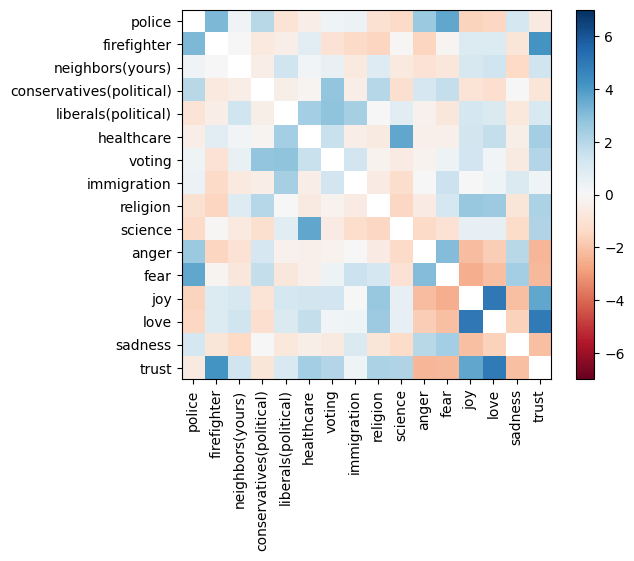

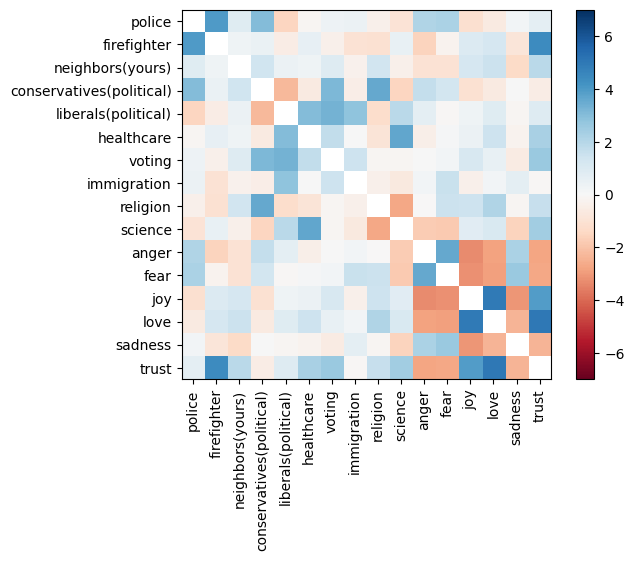

In [ ]:
# Generate distance matricies
bPRaM_Weights = weightedHeatmap(avgBSim, words,1); # Compute association matrix for Black participants
wPRaM_Weights = weightedHeatmap(avgWSim, words,1); # Compute association matrix for White participants

In [ ]:
# Splithalf Reliability
perm = 10000
rhobPRaM = splitHalf_Reliability(bPRaMz, perm)
rhowPRaM = splitHalf_Reliability(wPRaMz, perm)
print(f'PRaM reliability for Black sample:', round(rhobPRaM,2))
print(f'PRaM reliability for White sample:', round(rhowPRaM,2))

PRaM reliability for Black sample: 0.94
PRaM reliability for White sample: 0.92


In [ ]:
#Measure Word-Pair differences across group VARIABLES
#Regression model
#Y is pair-distance
#X contains all group breakdowns (dummy coded for discrete; sequentialized for ordinal variables)
#Permutation-testing and FDR (scramble Y)

#Group breakdown:
#----------------------------
#Race
#Gender
#SES
#Age
#[News consumption]=Political [CURRENTLY EXCLUDED]
#[Location ideology (Live)] [CURRENTLY EXCLUDED]
#----------------------------

#X: Variable processing
#Race [Black = 1; White = 0]
blackCode = np.concatenate([np.ones(len(bIndx)), np.zeros(len(wIndx))])

#Gender [Female = 1; Male = 0]
FInd = Gender.str.contains('F')
MInd = Gender.str.contains('M')
RInd = Gender.str.contains('R')
Gender.loc[FInd] = 1
Gender.loc[MInd] = 0
femaleCode = Gender

#SES [Higher value means higher income bracket]
i0Ind = Income.str.contains(pat = 'Less than $12500', case=False, regex=False)
i1Ind = Income.str.contains(pat = '$12501-$22500', case=False, regex=False)
i2Ind = Income.str.contains(pat = '$22501-$42500', case=False, regex=False)
i3Ind = Income.str.contains(pat = '$42501-$80000', case=False, regex=False)
i4Ind = Income.str.contains(pat = 'More than $80000', case=False, regex=False)
Income.loc[i0Ind] = 0
Income.loc[i1Ind] = 1
Income.loc[i2Ind] = 2
Income.loc[i3Ind] = 3
Income.loc[i4Ind] = 4

#Age
Age = Age

#Remove underrepesented gender identities (i.e, non-bianary)
blackCode = blackCode[~RInd]
femaleCode = femaleCode[~RInd]
Income = Income[~RInd]
Age = Age[~RInd]
NewsBias = NewsBias[~RInd]

#Remove participants who only consumed algorithmic news sources
remIdxNBias= NewsBias.str.contains(pat = 'x', case=False)
blackCode = blackCode[~remIdxNBias]
femaleCode = femaleCode[~remIdxNBias]
Income = Income[~remIdxNBias]
Age = Age[~remIdxNBias]
NewsBias = NewsBias[~remIdxNBias]


In [ ]:
#Reset index for series (just in case)
femaleCode = femaleCode.reset_index(drop=True)
femaleCode = femaleCode.to_numpy() #convert series to array
Income = Income.reset_index(drop=True)
Income = Income.to_numpy()  #convert series to array
NewsBias = NewsBias.reset_index(drop=True)
NewsBias = NewsBias.to_numpy()  #convert series to array

#Reshape for concatenation
blackCode =  blackCode.reshape(blackCode.shape[0],1)
femaleCode =  femaleCode.reshape(femaleCode.shape[0],1)
Income =  Income.reshape(Income.shape[0],1)
Age =  Age.reshape(Age.shape[0],1)
NewsBias = NewsBias.reshape(NewsBias.shape[0],1)

In [ ]:
#Execute model
#Concatonate
X = np.concatenate((blackCode, femaleCode, Income, Age, NewsBias), axis=1)

#Y: Pair data
PRaM_cat = np.concatenate([bPRaM, wPRaM])
PRaM_cat = PRaM_cat[~RInd,:]
PRaM_cat = PRaM_cat[~remIdxNBias,:]

bObsPairsPRaM = []
pPairsPRaM = []
perm = 1000
#Iterate through concept-pairs
for i in tqdm(range(len(wPairLabel))):
    # Isolate pair data
    Y = PRaM_cat[:,i]

    #Dummy coded linear regression
    #Compared against permuted distribution
    betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff(X, Y, perm)

    #Update output
    bObsPairsPRaM.append(betaObs_PRaM)
    pPairsPRaM.append(pval_PRaM)
    #if i == 0:
    #  plt.hist(betaPerm1)

pPairsPRaM = pd.DataFrame(pPairsPRaM) #Convert to dataframe
bObsPairsPRaM = pd.DataFrame(bObsPairsPRaM)#Convert to dataframe

#Implement FDR correction
FDR_sig = []
import statsmodels as sm
for g in range(X.shape[1]):
  FDR = sm.stats.multitest.fdrcorrection(np.array(pPairsPRaM[g+1]), alpha=0.05, method='indep', is_sorted=False)#+1 is to account for constant in original model
  FDR_sig.append(FDR[0])
FDR_sig = pd.DataFrame(FDR_sig)

100%|██████████| 120/120 [01:13<00:00,  1.63it/s]


In [ ]:
np.mean(NewsBias.astype('float'))

2.2922272047914793

In [ ]:
#Recompute descriptive statistics
AvgAge = round(np.mean(Age),2)
SDAge = round(np.std(Age),2)
propFemale = (sum(femaleCode==1)/len(femaleCode))*100
propFemale = round(propFemale[0],2)
AvgNewsBias = round(np.mean(NewsBias.astype('float')),2)
SDNewsBias = round(np.std(NewsBias.astype('float')),2)
#Race
#Income

print('The Mean age of sample used in model is:', AvgAge, '(SD =', SDAge, ')')
print('The sample is',propFemale, '% Female and', (100-propFemale),'% Male')
print('The Mean NewsBias of sample used in model is:', AvgNewsBias, '(SD =', SDNewsBias, '; 1=Left & 3=Center & 5=Right)')

The Mean age of sample used in model is: 40.56 (SD = 12.43 )
The sample is 49.55 % Female and 50.45 % Male
The Mean NewsBias of sample used in model is: 2.29 (SD = 1.23 ; 1=Left & 3=Center & 5=Right)


In [ ]:
#Export data to CSV files
FDR_sig.to_csv('FDRsig.csv')
pPairsPRaM.to_csv('pValPairs.csv')
bObsPairsPRaM.to_csv('bObsPairsPRaM.csv')
PRaM_cat.to_csv('PRaM_finalModel.csv')

In [ ]:
#Mediation analysis Race->NewsBias->ConceptGeometry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation

    Args:
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns:
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''

    SE = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    t = (a*b) / SE
    n = 100000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval

In [ ]:
# set random seed so everyone gets same results
np.random.seed(1)

# Determine effects
a = -3 # effect of x to M
b = 3 # effect of M to y
cq = .1 #  effect of x on y controlling for M

# Create a random data x
x = np.random.rand(100)
m = x * a + np.random.rand(100)

# Create Y
y = np.dot(np.array([x,m]).T,[cq,b]) + np.random.rand(100)

Text(0.5, 1.0, 'X -> Y')

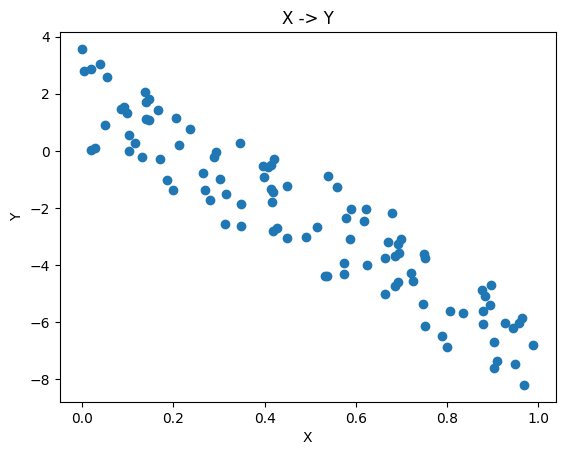

In [ ]:
plt.scatter(x,y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X -> Y')

Text(0.5, 1.0, 'X -> M')

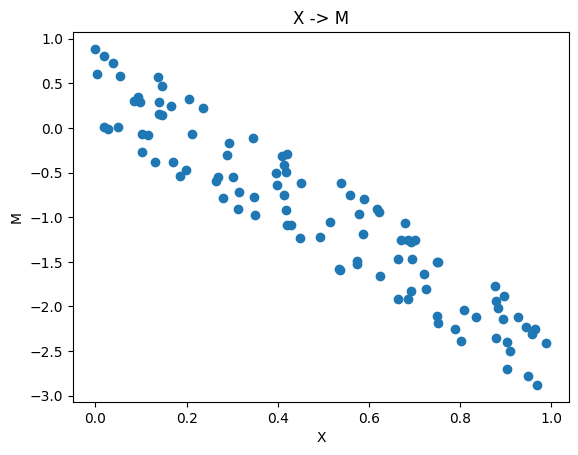

In [ ]:
plt.scatter(x,m)
plt.xlabel('X')
plt.ylabel('M')
plt.title('X -> M')

Text(0.5, 1.0, 'M -> Y')

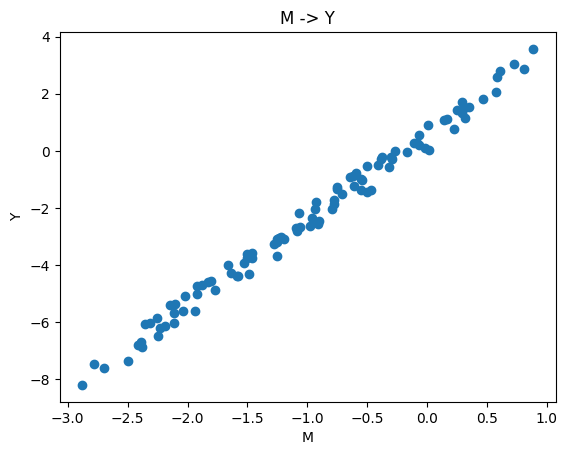

In [ ]:
plt.scatter(m,y)
plt.xlabel('M')
plt.ylabel('Y')
plt.title('M -> Y')

In [ ]:
#Test effect of X on Y
X = pd.DataFrame({'Intercept':np.ones(len(x)),'X':x})
lm1 = sm.OLS(y,X).fit()
print (lm1.summary())
ec = lm1.params[1] # save total effect c to ec

#Test effect of X on M
lm2 = sm.OLS(m,X).fit()
print (lm2.summary())
ea = lm2.params[1] # Save the effect of X on M, a, to ea
sea = lm2.bse[1]

#Test effect of X and M on Y
X['M'] = m
lm3 = sm.OLS(y,X).fit()
print (lm3.summary())
ecq,eb = lm3.params[1:3]
seb = lm3.bse[2]

print(ec) # ec
print(ea) #'a : %.2f') % ea
print(eb)#'b : %.2f') % eb
print(ecq) #'c\' : %.2f') % ecq

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     682.1
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           6.13e-46
Time:                        22:57:42   Log-Likelihood:                -142.55
No. Observations:                 100   AIC:                             289.1
Df Residuals:                      98   BIC:                             294.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0678      0.196     10.539      0.0

In [ ]:
#"{:.2f}".format(ec)
ec_p = '{:.2f}'.format(ec)
eaeb_p = '{:.2f}'.format(ea*eb)
ecq_p = '{:.2f}'.format(ecq)
tot_p = '{:.2f}'.format(ea*eb+ecq)

print('Total effect C:',ec_p) # ec
print('is decomposed into the indirect(mediated) effect a*b:', eaeb_p) # (ea*eb)
print('plus the direct effect c\':', ecq_p) # ecq
print('which adds up to', tot_p) # (ea*eb+ecq)

Total effect C: -9.02
is decomposed into the indirect(mediated) effect a*b: -9.27
plus the direct effect c': 0.25
which adds up to -9.02


In [ ]:
t,p = sobel_test(ea,eb,sea,seb)
t_p = '{:.2f}'.format(t)
p_p = '{:.2f}'.format(p)
print('Sobel\'s test of significance t =', t_p) # t
print('Two-tailed p-value p =', p_p) # p

Sobel's test of significance t = -21.76
Two-tailed p-value p = 0.00


In [ ]:
#Mediation analysis Race->NewsBias->ConceptGeometry

# import statsmodels.api as sm
# import statsmodels.genmod.families.links as links
# probit = links.probit
# outcome_model = sm.GLM.from_formula("cong_mesg ~ emo + treat + age + educ + gender + income", data, family=sm.families.Binomial(link=Probit()))
# mediator_model = sm.OLS.from_formula("emo ~ treat + age + educ + gender + income", data)
# med = Mediation(outcome_model, mediator_model, "treat", "emo").fit()
# med.summary()

In [ ]:
#Whole graph analysis
#Whole sample graph

#Generate graphs for each Where do I see group-based effects

#Force directed graph for each group. color-code each edge by pos/negative b
#Make non-significant edges partially translucent
#group-/variable- based differences


Graphical representation of conceptual associations for: Black sample


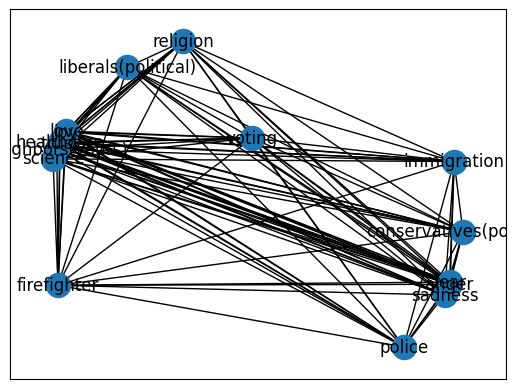

In [ ]:
#Generate Graph of conceptual associations for Black Sample
avgBSimT = tuple(avgBSim)

print("Graphical representation of conceptual associations for: Black sample")
G = nx.Graph()

for e in range(len(combinations_list)):
  G.add_edge(combinations_list[e][0], combinations_list[e][1], weight=avgBSimT[e])
pos = nx.spring_layout(G, iterations = 10000)
nx.draw_networkx(G,pos)


Graphical representation of conceptual associations for: White sample


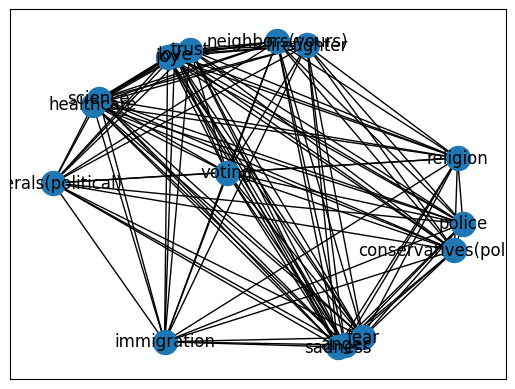

In [ ]:
#Generate Graph of conceptual associations for White Sample
G = nx.Graph()
avgWSimT = tuple(avgWSim)

print("Graphical representation of conceptual associations for: White sample")
for e in range(len(combinations_list)):
  G.add_edge(combinations_list[e][0], combinations_list[e][1], weight=avgWSimT[e])
pos = nx.spring_layout(G, iterations = 10000)
nx.draw_networkx(G,pos)

Cross median euclidean dist: {53.48831648126533}
Black median euclidean dist: {53.80520420925842}
White median euclidean dist: {52.55473337388365}


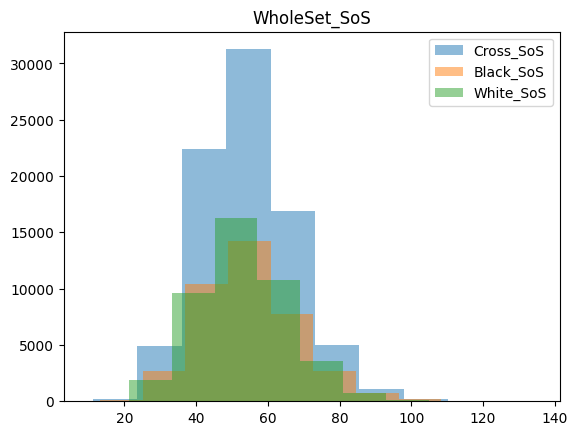

In [ ]:
#Compute distance analysis
#Reference: Local White Matter Architecture Defines Functional Brain Dynamics (Choe et al., 2018)

#Analysis structure
#Subract lower triangle between 2 participants (i.e., all unique distances)
#Compute euclidean distances for all combinations of participants within and across groups and plot histogram

#rerun permuting participant identity


#Whole-set Representational distances: Black Sample
z = 0
bPRaM = bPRaM.reset_index(drop=True)
bWS_dist = []
for i in range(len(bIndx)):
    for j in range(len(bIndx)):

        if j <= i:
          z += 1
        elif j > i:
          x = bPRaM.loc[i, :]
          y = bPRaM.loc[j, :]
          dist = np.linalg.norm(x-y)
          bWS_dist.append(dist)

#Whole-set Representational distances: White Sample
z = 0
wPRaM = wPRaM.reset_index(drop=True)
wWS_dist = []
for i in range(len(wIndx)):
    for j in range(len(wIndx)):

        if j <= i:
          z += 1
        elif j > i:
          x = wPRaM.loc[i, :]
          y = wPRaM.loc[j, :]
          xyDiff = x-y
          dist = np.linalg.norm(x-y)
          wWS_dist.append(dist)

#Whole-set Representational distances: Cross Racial Identities
xWS_dist = []
for i in range(len(bIndx)):
    for j in range(len(wIndx)):
        x = bPRaM.loc[i, :]
        y = wPRaM.loc[j, :]
        xyDiff = x-y
        dist = np.linalg.norm(x-y)
        xWS_dist.append(dist)

#Report median Euclidean distances
print(f'Cross median euclidean dist:',{np.median(xWS_dist)})
print(f'Black median euclidean dist:',{np.median(bWS_dist)})
print(f'White median euclidean dist:',{np.median(wWS_dist)})

#F = np.median(bWS_SoS)/np.sqrt((np.median(bWS_SoS)*np.median(wWS_SoS)))
#print(f'F-ratio across groups:',{F})

# Plot age histograms
plt.hist(xWS_dist,
         alpha=0.5,
         label='Cross_EucDist')

plt.hist(bWS_dist,
         alpha=0.5,
         label='Black_EucDist')

plt.hist(wWS_dist,
         alpha=0.5,
         label='White_EucDist')

plt.legend(loc='upper right')
plt.title('WholeSet_EucDist')
plt.show()

In [ ]:
#Histograph of ratings by group

100%|██████████| 120/120 [02:12<00:00,  1.11s/it]


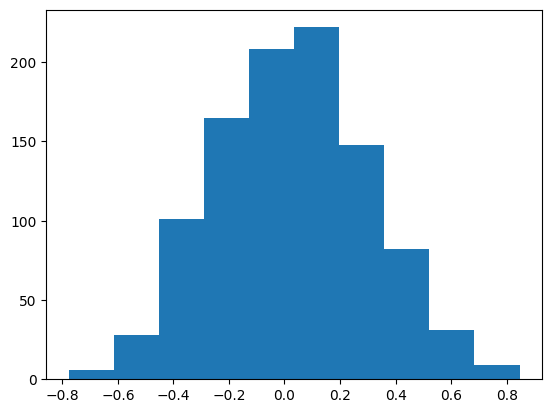

In [ ]:
#Measure Word-Pair differences across groups
#Dummy coded linear regression

# blackCode = np.concatenate([np.ones(len(bIndx)), np.zeros(len(wIndx))])
# perm = 1000

# # Concatonate data Needs to be structured as Pair-by-participants
# # Original
# PRaM_cat = np.concatenate([bPRaM, wPRaM])


# bObsPairsPRaM = []
# pPairsPRaM = []
# z = 0

# #Iterate through concept-pairs
# for i in tqdm(range(len(wPairLabel))):


#     # Isolate pair data
#     yPRaM = PRaM_cat[:,i]

#     #Dummy coded linear regression
#     #Compared against permuted distribution
#     betaObs_PRaM, pval_PRaM, betaPerm1 = regPairDiff(blackCode, Age, yPRaM, perm)

#     #Update output
#     bObsPairsPRaM.append(betaObs_PRaM)
#     pPairsPRaM.append(pval_PRaM)
#     if i == 0:
#       plt.hist(betaPerm1)

# #Implement FDR correction
# import statsmodels as sm
# FDR_sig = sm.stats.multitest.fdrcorrection(pPairsPRaM, alpha=0.05, method='indep', is_sorted=False)

In [ ]:
#PCA Analysis
bw_PRaM = np.vstack([bPRaM, wPRaM])

# Extract of participant's race i.e. white or black.
# Extract of participant's race i.e. white or black.
bw_Race = datDemo.iloc[np.concatenate([bIndx, wIndx]), 16]

# Create an instance of the LabelEncoder class
encoder = LabelEncoder()

# Fit and transform the data using the encoder
Y_race = encoder.fit_transform(bw_Race)

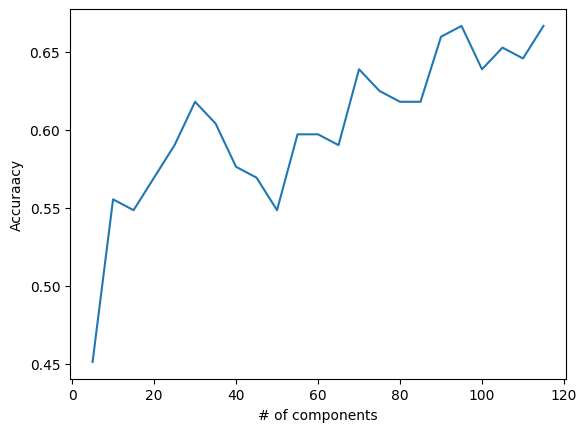

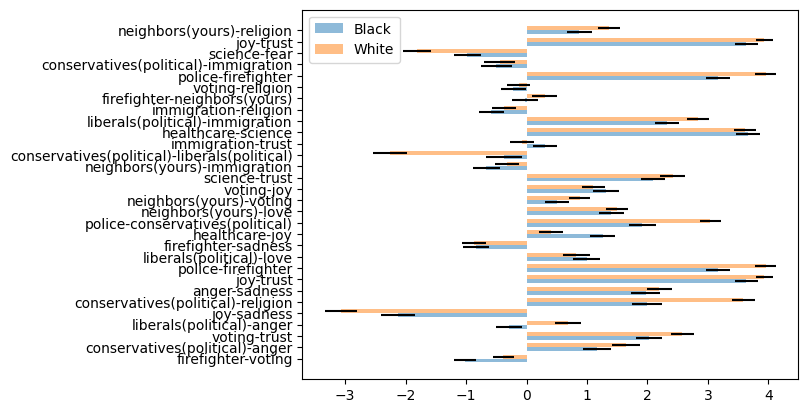

In [ ]:
bw_PRaM = np.vstack([bPRaM, wPRaM])

# Extract of participant's race i.e. white or black.
# Extract of participant's race i.e. white or black.
bw_Race = datDemo.iloc[np.concatenate([bIndx, wIndx]), 16]


# Create an instance of the LabelEncoder class
encoder = LabelEncoder()

# Fit and transform the data using the encoder
Y_race = encoder.fit_transform(bw_Race)

# # Remove IDX column from bw_PRaM

# bw_PRaM = bw_PRaM[:,:]

# Feature extraction using PCA
bw_PRaM_standarized = (bw_PRaM - np.mean(bw_PRaM, axis=0))/np.std(bw_PRaM,axis=0)

acc = []
n_com = []
feature_group = []
for i in range(5,120,5):
    n_com.append(i)

    # Fit the PCA with 10 components
    pca = PCA(n_components=i)
    pca.fit(bw_PRaM_standarized)


    # Extract the top features
    top_features = np.abs(pca.components_).argmax(axis=1).tolist()
    PRam_features = list(datPRaM_conSort.iloc[:, top_features].columns)
    feature_group.append(PRam_features)


    # Logistic regression model
    X = bw_PRaM_standarized[:,top_features]


    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y_race, test_size=0.25, random_state=42)

    # Create an instance of the model and fit the data
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict test data
    y_pred = model.predict(X_test)

    # Evaluate the performance of the model

    acc.append(accuracy_score(y_test, y_pred))



# figure
plt.plot(n_com, acc)
plt.xlabel('# of components')
plt.ylabel('Accuraacy')



# Examine the top features
n = 5
top_PRAM = datPRaM_conSort[feature_group[n]]

bPRaM_feat = top_PRAM.iloc[bIndx,:]
wPRaM_feat = top_PRAM.iloc[wIndx,:]

# Average pair distance
avgBSim_feat = np.mean(bPRaM_feat, axis=0)
avgWSim_feat = np.mean(wPRaM_feat, axis=0)

# SEM pair distance
semBSim_feat = np.std(bPRaM_feat, axis=0)/np.sqrt(bPRaM_feat.shape[0])
semWSim_feat = np.std(wPRaM_feat, axis=0)/np.sqrt(wPRaM_feat.shape[0])

# maintain polarity
bPRaMz_feat = stats.zscore(bPRaM_feat, axis=0)
wPRaMz_feat = stats.zscore(wPRaM_feat, axis=0)

# Compute mean normalized association
bPRaMz_avg_feat = np.mean(bPRaMz_feat, axis=0);
wPRaMz_avg_feat = np.mean(wPRaMz_feat, axis=0);


# Visualization

# Set bar width and positions
bar_width = 0.35
r1 = np.arange(len(avgBSim_feat))
r2 = [x + bar_width for x in r1]

# Plot grouped bar chart with error bars
fig, ax = plt.subplots()
ax.barh(r1, avgBSim_feat, xerr=semBSim_feat, height=bar_width, alpha=0.5, label='Black')
ax.barh(r2, avgWSim_feat, xerr=semWSim_feat, height=bar_width, alpha=0.5, label='White')
ax.set_yticks([r + bar_width / 2 for r in range(len(avgBSim_feat))])
ax.set_yticklabels(feature_group[n], rotation=0)
# ax.set_ylabel('Values')
# ax.set_title('Grouped Bar Plot with Error Bars')
ax.legend()
plt.show()


In [ ]:
# Clustering of each racial group
white_pca = PCA(n_components=2).fit_transform(wPRaM.iloc[:,1:])
black_pca = PCA(n_components=2).fit_transform(bPRaM.iloc[:,1:])


bw_PRaM = pd.DataFrame(bw_PRaM)

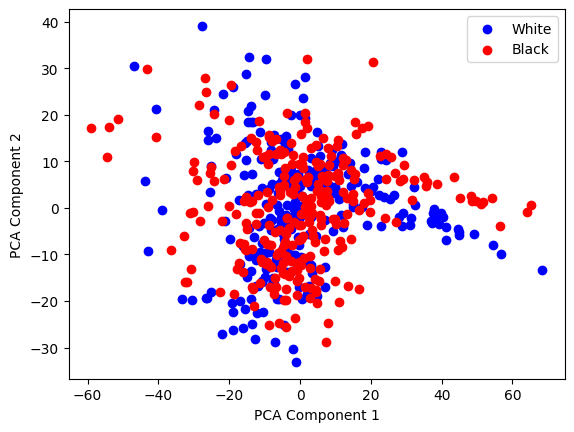

In [ ]:
# Visualization of results
plt.scatter(white_pca[:,0], white_pca[:,1], color='b', label='White')
plt.scatter(black_pca[:,0], black_pca[:,1], color='r', label='Black')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [ ]:

acc = []
features = []
for i in range(5,120,5):

  # Feature selection techniques
  # Univariate ANOVA
  anova = SelectKBest(score_func=f_classif, k=i)
  X = bw_PRaM
  X_anova = anova.fit_transform(X, Y_race)
  feature_index = X.columns[anova.get_support()]
  feature_index = X.columns[anova.get_support()]
  feature_names = list(datPRaM_conSort.iloc[:, feature_index].columns)
  features.append(feature_names)
  X = bw_PRaM_standarized[:,feature_index]


  # Split the data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y_race, test_size=0.25, random_state=42)

  # Create an instance of the model and fit the data
  model = LogisticRegression()
  model.fit(X_train, y_train)

  # Predict test data
  y_pred = model.predict(X_test)

  # Evaluate the performance of the model

  acc.append(accuracy_score(y_test, y_pred))

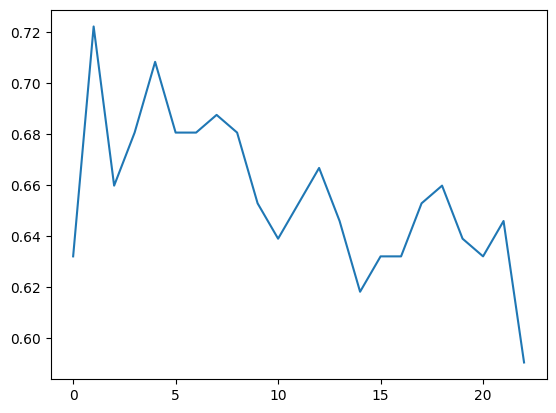

In [ ]:
plt.plot(acc)

In [ ]:
# Change index for features and accuracy to see how the combination of features perform with the logistic regression.
print(f'The following features{features[0]} predict with {acc[0]*100}% of the time')

The following features['police-fear', 'firefighter-conservatives(political)', 'neighbors(yours)-conservatives(political)', 'conservatives(political)-liberals(political)', 'conservatives(political)-religion'] predict with 63.19444444444444% of the time
